In [1]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
(train_X,train_y),(test_X,test_y)=load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
train_X[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

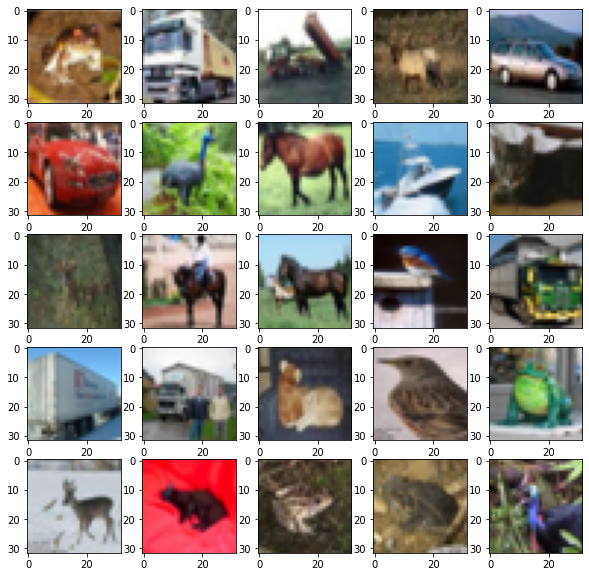

In [5]:
#print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_X[i])

# **Discriminator**
4 convolutional layers and 1 fully connected layer

In [6]:
def discriminator():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3),padding='same',input_shape=train_X[0].shape),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same'), #become(4*4*256)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    opt=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5) #adam version of stochastic gradient
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
    #model.summary()
    return model

# **Generator**
* input: Point in latent space, e.g. a 100-element vector of Gaussian random numbers
* output: Image with pixel value [-1,1]

In [30]:
def generator():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Dense(4*4*256,input_dim=latent_dim),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((4,4,256)), #become(4*4*256)
        #to 8*8
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 16*16
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 32*32
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 32*32*3 image
        tf.keras.layers.Conv2D(3,(3,3),activation='tanh',padding='same')
    ])
    return model

Image_Generator for Discriminator: sampling real image&generate fake image for Discriminator for training

In [8]:
def real_image_generator(dataset,num):
    rand=np.random.randint(0,dataset.shape[0],num)
    X=dataset[rand]
    y=np.ones((num,1))
    return X,y

In [31]:
def fake_image_generator(g_model,num):
    X=np.random.randn(num,latent_dim)
    #G(z)
    X=g_model.predict(X)
    y=np.zeros((num,1))
    return X,y

# **Training**
* For each example input generate an output.
* The discriminator receives the input image and the generated image as the first input. The second input is the input image and the target image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to summarize_performance.

In [10]:
def gan(g_model,d_model):
    d_model.trainable=False
    model=tf.keras.models.Sequential([g_model,d_model])
    opt=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [42]:
def fit(g_model,d_model,dataset,epochs=20,batch_size=64):
    gan_model=gan(g_model,d_model)
    batches=dataset.shape[0]//batch_size
    for epoch in range(1,epochs+1):
        for batch in range(1,batches+1):
            #fit discriminator,half real image half fake image
            X,y=real_image_generator(dataset,batch_size//2)
            loss_d1,_=d_model.train_on_batch(X,y)
            X,y=fake_image_generator(g_model,batch_size//2)
            loss_d2,_=d_model.train_on_batch(X,y)
            #fit generator
            X=np.random.randn(batch_size,latent_dim)
            y=np.ones((batch_size,1))
            loss_g=gan_model.train_on_batch(X,y)
            print('epoch{} {}/{} loss_d1:{:.2f},loss_d2:{:.2f},loss_g:{:.2f}'.format(epoch,batch,batches,loss_d1,loss_d2,loss_g))
        if epoch%5==0:
            summarize_performance(epoch,g_model,d_model,dataset)

In [12]:
def summarize_performance(epoch,g_model,d_model,dataset,num=100):
    #show acc
    X,y=real_image_generator(dataset,num)
    _,acc_real=d_model.evaluate(X,y,verbose=0)
    X,y=fake_image_generator(g_model,num)
    _,acc_fake=d_model.evaluate(X,y,verbose=0)
    print('evaluate acc_fake:{:.2f} aacc_real:{:.2f}'.format(acc_fake*100,acc_real*100))
    #save fake img
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow((X[i]+1)/2) #from [-1,1] to [0,1]
    plt.savefig('GAN CIFAR-10\\fakeImg epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_model.save('GAN CIFAR-10\\generator epoch{}.h5'.format(epoch))

**Image's pixel range from [0,255] to [-1,1]**

The generator model will generate images with pixel values in the range [-1,1] as it will use the tanh activation function, a best practice.
We will used only train_X for GAN.
train_y,test_X,test_y will be abandoned.

In [13]:
(train_X,_),(_,_)=load_data()
train_X=(train_X.astype(float)-127.5)/127.5

**Define Latent Space**

can be 10,20,50,100... each dimension represent specific features

In [29]:
latent_dim=10

In [43]:
g_model=generator()
d_model=discriminator()
fit(g_model,d_model,train_X)

流式输出内容被截断，只能显示最后 5000 行内容。
epoch14 471/781 loss_d1:0.68,loss_d2:0.73,loss_g:0.97
epoch14 472/781 loss_d1:0.68,loss_d2:0.54,loss_g:1.07
epoch14 473/781 loss_d1:0.68,loss_d2:0.57,loss_g:1.02
epoch14 474/781 loss_d1:0.66,loss_d2:0.63,loss_g:0.91
epoch14 475/781 loss_d1:0.69,loss_d2:0.61,loss_g:0.94
epoch14 476/781 loss_d1:0.63,loss_d2:0.56,loss_g:0.91
epoch14 477/781 loss_d1:0.61,loss_d2:0.54,loss_g:0.96
epoch14 478/781 loss_d1:0.56,loss_d2:0.83,loss_g:0.95
epoch14 479/781 loss_d1:0.74,loss_d2:0.60,loss_g:0.95
epoch14 480/781 loss_d1:0.69,loss_d2:0.59,loss_g:0.94
epoch14 481/781 loss_d1:0.66,loss_d2:0.64,loss_g:0.97
epoch14 482/781 loss_d1:0.84,loss_d2:0.71,loss_g:0.92
epoch14 483/781 loss_d1:0.79,loss_d2:0.57,loss_g:0.96
epoch14 484/781 loss_d1:0.75,loss_d2:0.62,loss_g:0.95
epoch14 485/781 loss_d1:0.77,loss_d2:0.66,loss_g:0.95
epoch14 486/781 loss_d1:0.68,loss_d2:0.61,loss_g:0.97
epoch14 487/781 loss_d1:0.73,loss_d2:0.65,loss_g:0.89
epoch14 488/781 loss_d1:0.63,loss_d2:0.62,loss_g:0.84
e

# **Results**

In [44]:
model=tf.keras.models.load_model('GAN CIFAR-10\\generator epoch20.h5')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


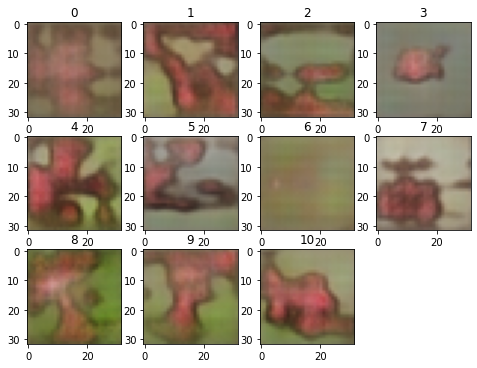

In [45]:
vectors=np.zeros((11,10),float)
for i in range(10):
    vectors[i+1,i]=1
print(vectors)
images=model.predict(vectors)
images=(images+1)/2 #from [-1,1] to [0,1]
plt.figure(figsize=(8,8))
for i in range(11):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(i)

[[-0.82848205  0.62728586 -0.57173916  1.38416991  0.52890145 -1.2538294
   0.21859332  1.68496084  0.68677141 -0.24331253]]


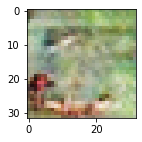

In [46]:
vector=np.random.randn(1,latent_dim)
print(vector)
image=model.predict(vector)
image=(image+1)/2
plt.figure(figsize=(2,2))
plt.imshow(image[0])

# **Summary and my learning outcomes**
To get the best result (which means that the predicted image is accurate and close to the training image), I think we can try different settings, such as changing epoch, amount of hidden layers, batch size, latent space, etc. After I implement different settings, I noticed that the neural netwotk with 4 hidden layers is optimal. More epochs make more accuracy, but it may be too time-consuming when the amount of epochs is large enough (like 100). And there also exists the optimal batch size and latent space. Latent space 10 is apparently better than 20, 50, 100... And batch size 64 is better than 128 and 256.

To sum up, GAN can be trained using back-propagation for Neural Network based Generator/Discriminator functions. With GAN, sharper images can be generated, and it will be faster to sample from the model distribution: single forward pass generates a single sample. Thus, GAN is a good way for generation.